<a href="https://colab.research.google.com/github/VasileiosKarapoulios/Object-Localization/blob/master/Object_Localization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**For the purpose of this project, Google Colab was used to perform completely the entire task.**

**Also, tensorflow 2.3 and keras 2.4 were used**

In [ ]:
!pip install tensorflow==2.3
!pip install keras==2.4

In [ ]:
import os
import warnings

# Ignore FutureWarning from numpy
warnings.simplefilter(action='ignore', category=FutureWarning)

import keras.backend as K
import tensorflow as tf

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
 
# The GPU id to use, usually either "0" or "1";
os.environ["CUDA_VISIBLE_DEVICES"]="0";

# Google Drive
**Connecting Google Drive, because the data used in this project are stored there and used directly.**

In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Import dependencies and check how the data look like. The two dots represent the two of the edges of the box (upper left and lower right).**

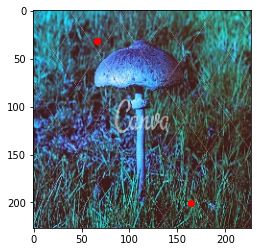

In [ ]:
# Importing Dependencies
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from random import shuffle

img_array = np.load("/content/drive/My Drive/object_localization.npy", allow_pickle=True)

test = np.array(img_array[730][0]).reshape(-1,227,227,3)
plt.imshow(test[0])
plt.plot(img_array[730][2][0], img_array[730][2][1], 'o', color='red')
plt.plot(img_array[730][2][2], img_array[730][2][3], 'o', color='red')
plt.show()

**Separate train and validation.**

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

#Separating train and validation sets
data = np.load('/content/drive/My Drive/object_localization.npy', allow_pickle=True)
train = data[:int(len(data)*0.8)]
cv = data[int(len(data)*0.8):]

# X for train input
X = np.array([i[0] for i in train]).reshape(-1,227,227,3)
# Y for classification head
Y = np.array([i[1] for i in train])
# Y2 for regression head
Y2 = np.array([i[2] for i in train])

# cv_x for train input
cv_x = np.array([i[0] for i in cv]).reshape(-1,227,227,3)
# cv_y for classification head
cv_y = np.array([i[1] for i in cv])
# cv_y2 for regression head
cv_y2 = np.array([i[2] for i in cv])

print(X.shape)
print(cv_x.shape)

(1190, 227, 227, 3)
(298, 227, 227, 3)


# Model 
**Here we build the model, using the functional API, which will consist of two "branches", one for regression and one for classification.**

In [ ]:
from keras.models import Sequential, Model
from keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense, Dropout, SpatialDropout2D
from keras.optimizers import Adam
from keras.losses import categorical_crossentropy, mean_squared_error

# Set seed from random number generator, for better comparisons
from numpy.random import seed
seed(123)

def model_test():

    # Setup input 
    main_input = Input(shape=(227,227,3), name='main_input')

    # Add first convolutional layer to the model, requires input shape
    x = Conv2D(filters=64, kernel_size=(3, 3),  
                      padding="same", activation="relu",  
                      kernel_initializer='he_normal')(main_input)
    x = BatchNormalization()(x)                  
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    
    x1 = Conv2D(filters=64, kernel_size=(3, 3),  
                    padding="same", activation="relu",  
                    kernel_initializer='he_normal')(x)               
    x1 = BatchNormalization()(x1)
    x1 = MaxPooling2D(pool_size=(2, 2))(x1)
    x1 = SpatialDropout2D(0.05)(x1)

    for i in range(2):
      x1 = Conv2D(filters=64*(i+2), kernel_size=(3, 3),  
                    padding="same", activation="relu",  
                    kernel_initializer='he_normal')(x1)               
      x1 = BatchNormalization()(x1)
      x1 = MaxPooling2D(pool_size=(2, 2))(x1)
      x1 = SpatialDropout2D(0.05)(x1)

    x1 = Flatten()(x1)
    
    # Add intermediate dense layers
    for i in range(2):
      x1 = Dense(1024, activation='relu', kernel_initializer='he_normal')(x1)
      x1 = BatchNormalization()(x1)
      x1 = Dropout(0.5)(x1)

    x2 = Conv2D(filters=64*(2), kernel_size=(3, 3),  
                    padding="same", activation="relu",  
                    kernel_initializer='he_normal')(x)               
    x2 = BatchNormalization()(x2)
    x2 = MaxPooling2D(pool_size=(2, 2))(x2)
    x2 = SpatialDropout2D(0.05)(x2)

    for i in range(3):
      x2 = Conv2D(filters=64*(i+3), kernel_size=(3, 3),  
                    padding="same", activation="relu",  
                    kernel_initializer='he_normal')(x2)               
      x2 = BatchNormalization()(x2)
      x2 = MaxPooling2D(pool_size=(2, 2))(x2)
      x2 = SpatialDropout2D(0.05)(x2)

    x2 = Flatten()(x2)

    # Add intermediate dense layers
    for i in range(2):
      x2 = Dense(2048, activation='relu', kernel_initializer='he_normal')(x2)
      x2 = BatchNormalization()(x2)
      x2 = Dropout(0.5)(x2)

    out1 = Dense(3, activation = 'softmax', name='classification')(x1)
    out2 = Dense(4, activation='relu', name='regression')(x2)

    model = Model(inputs = main_input, outputs=[out1,out2])

    # Compile model
    model.compile(loss=['categorical_crossentropy', 'mean_squared_error'],
                  optimizer=Adam(learning_rate=0.01), 
                  metrics=['accuracy'])

    return model

# Training 
**We will try to train the network separately for the classification branch and then for the regression branch. The reason for this, is that because the loss function is defined as the sum of the two loss functions, and the loss for the classification usually varies between 0-1 while the loss for the regression varies between 150-500, this results the classification loss improvement being irrelevant to the total loss. A way to avoid this would be to implement a custom loss function, so that training the whole network at once would be efficient. Also, the fact that Google Colab is used, adds some restrictions in training a very deep/wide network (in terms of memory provided).** 



In [ ]:
from numpy.random import seed
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model

K.clear_session()
seed(123)

# Setup some training parameters
batch_size = 64
epochs = 1

# Build model
model = model_test()

history = model.fit(X,[Y,Y2], batch_size=batch_size, epochs=epochs, validation_split=0.1)

17/17 [==============================] - 17s 1s/step - loss: 10687.3408 - classification_loss: 1.4535 - regression_loss: 10685.8848 - classification_accuracy: 0.7077 - regression_accuracy: 0.5107 - val_loss: 25394.4004 - val_classification_loss: 6553.1973 - val_regression_loss: 18841.2031 - val_classification_accuracy: 0.3025 - val_regression_accuracy: 0.0000e+00


# Model summary

In [ ]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         [(None, 227, 227, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 227, 227, 64) 1792        main_input[0][0]                 
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 227, 227, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 113, 113, 64) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

# Model Architecture

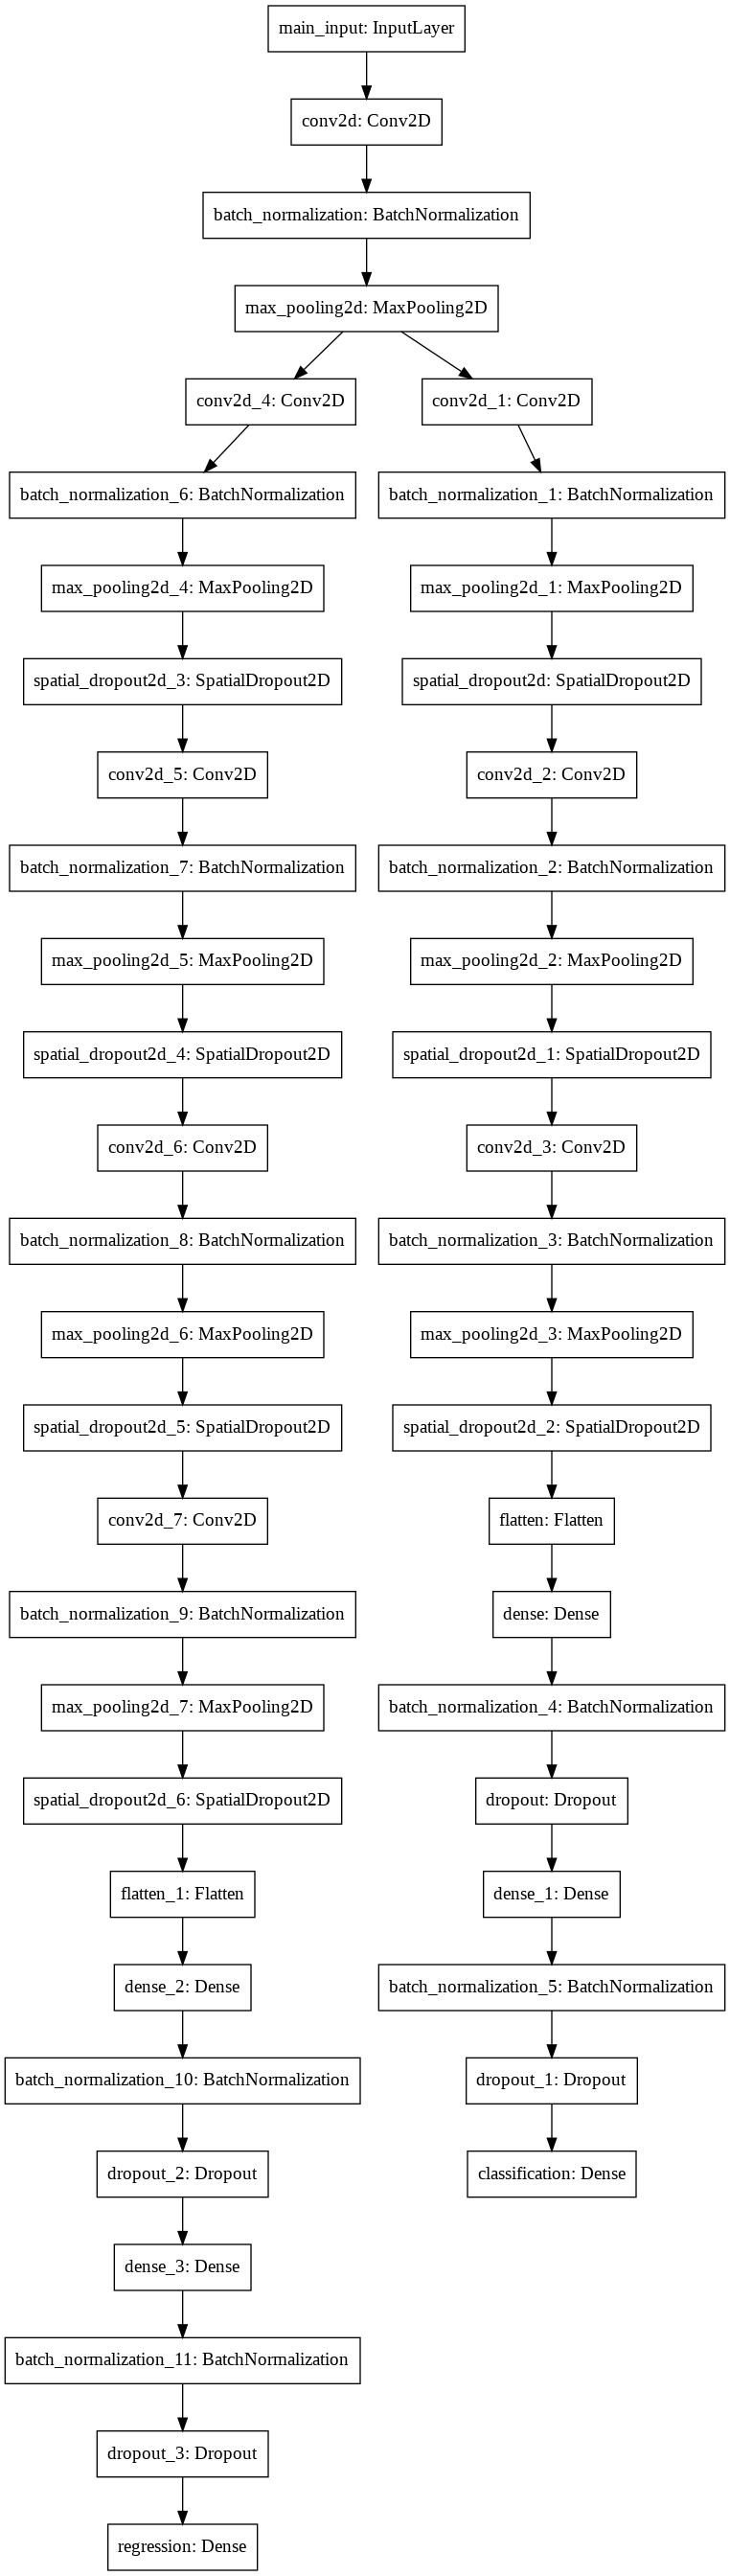

In [ ]:
import keras
keras.utils.plot_model(model, "model.png")

**We first train the whole network for 1 epoch, just to get some initial weights, so that we can freeze the layers we want afterwards and continue training.**

**Here we will freeze the layers that correspond to the regression part.**

In [ ]:
# regression layers

model.layers[4].trainable=False
model.layers[5].trainable=False
model.layers[6].trainable=False
model.layers[7].trainable=False
model.layers[9].trainable=False
model.layers[11].trainable=False
model.layers[13].trainable=False
model.layers[15].trainable=False
model.layers[17].trainable=False
model.layers[19].trainable=False
model.layers[21].trainable=False
model.layers[23].trainable=False
model.layers[25].trainable=False
model.layers[27].trainable=False
model.layers[29].trainable=False
model.layers[31].trainable=False
model.layers[33].trainable=False
model.layers[35].trainable=False
model.layers[37].trainable=False
model.layers[39].trainable=False
model.layers[41].trainable=False
model.layers[43].trainable=False
model.layers[45].trainable=False
model.layers[47].trainable=False

model.compile(loss=['categorical_crossentropy', 'mean_squared_error'],
                  optimizer=Adam(learning_rate=0.01), 
                  metrics=['accuracy'])

In [ ]:
from numpy.random import seed
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model

seed(123)

es = EarlyStopping(monitor='val_classification_loss', mode='min', verbose=1, patience=15)
mc = ModelCheckpoint('best_model.h5', monitor='val_classification_loss', mode='min', save_best_only=True, verbose=1)

# Setup some training parameters
batch_size = 64
epochs = 50

history = model.fit(X,[Y,Y2], batch_size=batch_size, epochs=epochs, validation_split=0.1, callbacks=[es, mc], verbose=1)

# load a saved model
model = load_model('best_model.h5')

Epoch 1/50
17/17 [==============================] - ETA: 0s - loss: 18751.6387 - classification_loss: 0.9163 - regression_loss: 18750.7227 - classification_accuracy: 0.8571 - regression_accuracy: 0.0000e+00
Epoch 00001: val_classification_loss improved from inf to 27.07375, saving model to best_model.h5
17/17 [==============================] - 13s 763ms/step - loss: 18751.6387 - classification_loss: 0.9163 - regression_loss: 18750.7227 - classification_accuracy: 0.8571 - regression_accuracy: 0.0000e+00 - val_loss: 18868.2773 - val_classification_loss: 27.0738 - val_regression_loss: 18841.2031 - val_classification_accuracy: 0.8487 - val_regression_accuracy: 0.0000e+00
Epoch 2/50
17/17 [==============================] - ETA: 0s - loss: 18753.9746 - classification_loss: 0.2931 - regression_loss: 18753.6797 - classification_accuracy: 0.9514 - regression_accuracy: 0.0000e+00
Epoch 00002: val_classification_loss did not improve from 27.07375
17/17 [==============================] - 10s 600ms

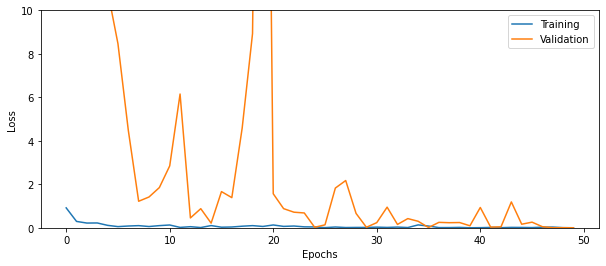

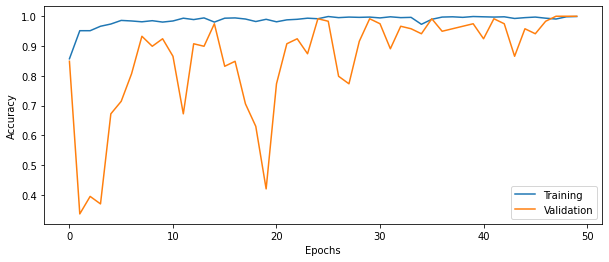

In [ ]:
def plot_results(history):
    
    loss = history.history['classification_loss']
    acc = history.history['classification_accuracy']
    val_class_loss = history.history['val_classification_loss']
    val_class_acc = history.history['val_classification_accuracy']
    
    plt.figure(figsize=(10,4))
    plt.ylim(0,10)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(loss)
    plt.plot(val_class_loss)
    plt.legend(['Training','Validation'])

    plt.figure(figsize=(10,4))
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(acc)
    plt.plot(val_class_acc)
    plt.legend(['Training','Validation'])

    plt.show()

plot_results(history)

**Here we freeze the layers that correspond to the classification part and unfreeze the rest**

In [ ]:
K.clear_session()
model = load_model('best_model.h5')

# regression
model.layers[4].trainable=True
model.layers[5].trainable=True
model.layers[6].trainable=True
model.layers[7].trainable=True
model.layers[9].trainable=True
model.layers[11].trainable=True
model.layers[13].trainable=True
model.layers[15].trainable=True
model.layers[17].trainable=True
model.layers[19].trainable=True
model.layers[21].trainable=True
model.layers[23].trainable=True
model.layers[25].trainable=True
model.layers[27].trainable=True
model.layers[29].trainable=True
model.layers[31].trainable=True
model.layers[33].trainable=True
model.layers[35].trainable=True
model.layers[37].trainable=True
model.layers[39].trainable=True
model.layers[41].trainable=True
model.layers[43].trainable=True
model.layers[45].trainable=True
model.layers[47].trainable=True

# classification
model.layers[0].trainable=False
model.layers[1].trainable=False
model.layers[2].trainable=False
model.layers[3].trainable=False
model.layers[8].trainable=False
model.layers[10].trainable=False
model.layers[12].trainable=False
model.layers[14].trainable=False
model.layers[16].trainable=False
model.layers[18].trainable=False
model.layers[20].trainable=False
model.layers[22].trainable=False
model.layers[24].trainable=False
model.layers[26].trainable=False
model.layers[28].trainable=False
model.layers[30].trainable=False
model.layers[32].trainable=False
model.layers[34].trainable=False
model.layers[36].trainable=False
model.layers[38].trainable=False
model.layers[40].trainable=False
model.layers[42].trainable=False
model.layers[44].trainable=False
model.layers[46].trainable=False

model.compile(loss=['categorical_crossentropy', 'mean_squared_error'],
                  optimizer=Adam(learning_rate=0.05), 
                  metrics=['accuracy'])

In [ ]:
from numpy.random import seed
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model

seed(123)

es = EarlyStopping(monitor='val_regression_loss', mode='min', verbose=1, patience=20)
mc = ModelCheckpoint('best_model_r.h5', monitor='val_regression_loss', mode='min', save_best_only=True, verbose=1)

# Setup some training parameters
batch_size = 64
epochs = 100

history = model.fit(X,[Y,Y2], batch_size=batch_size, epochs=epochs, validation_split=0.1, callbacks=[es, mc], verbose=1)

# load a saved model
model = load_model('best_model_r.h5')

Epoch 1/100
17/17 [==============================] - ETA: 0s - loss: 4268.5850 - classification_loss: 7.7846e-05 - regression_loss: 4268.5850 - classification_accuracy: 1.0000 - regression_accuracy: 0.6125
Epoch 00001: val_regression_loss improved from inf to 18841.20312, saving model to best_model_r.h5
17/17 [==============================] - 9s 558ms/step - loss: 4268.5850 - classification_loss: 7.7846e-05 - regression_loss: 4268.5850 - classification_accuracy: 1.0000 - regression_accuracy: 0.6125 - val_loss: 18841.2051 - val_classification_loss: 8.4993e-04 - val_regression_loss: 18841.2031 - val_classification_accuracy: 1.0000 - val_regression_accuracy: 0.0000e+00
Epoch 2/100
17/17 [==============================] - ETA: 0s - loss: 2019.6003 - classification_loss: 2.3461e-04 - regression_loss: 2019.6001 - classification_accuracy: 1.0000 - regression_accuracy: 0.6489
Epoch 00002: val_regression_loss improved from 18841.20312 to 13752.67188, saving model to best_model_r.h5
17/17 [====

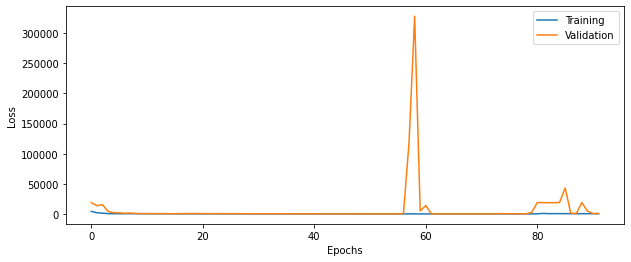

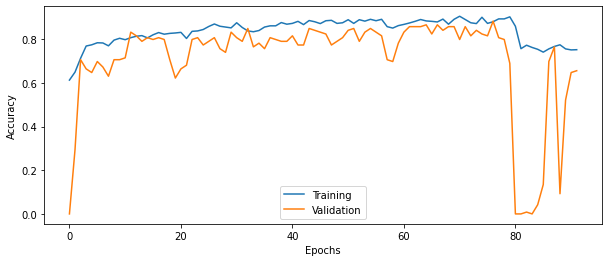

In [ ]:
def plot_results(history):
    
    loss = history.history['regression_loss']
    acc = history.history['regression_accuracy']
    val_regr_loss = history.history['val_regression_loss']
    val_regr_acc = history.history['val_regression_accuracy']
    
    plt.figure(figsize=(10,4))
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(loss)
    plt.plot(val_regr_loss)
    plt.legend(['Training','Validation'])

    plt.figure(figsize=(10,4))
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(acc)
    plt.plot(val_regr_acc)
    plt.legend(['Training','Validation'])

    plt.show()

plot_results(history)

**Then we'll check the accuracy based on the validation set.**

In [ ]:
results = model.evaluate(cv_x, [cv_y, cv_y2], batch_size=64)
print("Classification accuracy: ", results[3])
print("Regression accuracy: ", results[4])

5/5 [==============================] - 1s 151ms/step - loss: 123.1582 - classification_loss: 0.0433 - regression_loss: 123.1149 - classification_accuracy: 0.9866 - regression_accuracy: 0.8221
Classification accuracy:  0.9865771532058716
Regression accuracy:  0.8221476674079895


<function matplotlib.pyplot.show>

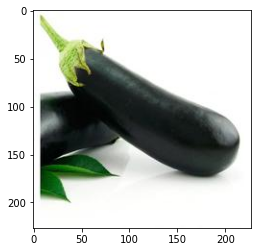

In [ ]:
import matplotlib.image as mpimg
from PIL import Image
import cv2

img = Image.open('testc.jpg')
new_width  = 227
new_height = 227
img = img.resize((new_width, new_height), Image.ANTIALIAS)
img.save('test.jpg') 

im = cv2.imread('test.jpg')
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)   # BGR -> RGB
im = im[np.newaxis, ...]

plt.imshow(im[0,:, :, :])
plt.show

In [ ]:
test = model.predict(im)

# Grad-CAM 
**Next, we will use the Gradient-weighted Class Activation Mapping to visualize class activation maps. This way, we will try to figure out how to network reached its final output looking at the final convolutional layer (that corresponds to the classification part).**

Target Class = 1


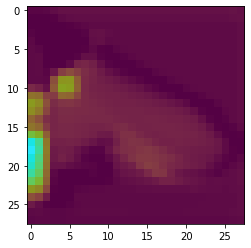

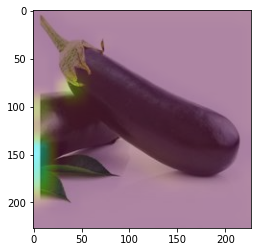

In [ ]:
target_class = np.argmax(test[0][0])
print("Target Class = %d"%target_class)

#we find the gradients of the target class score with respect to the feature maps of the last convolutional layer.
#Intuitively it tells us how important each channel is with regard to the target class. 
#The variable grads return a tensor which will be used in the following steps.
last_conv = model.get_layer('conv2d_3')
grads = K.gradients(model.output[0][:,target_class],last_conv.output)[0]

#The gradients thus obtained are then global average pooled to obtain the neuron important weights ak corresponding to
#the target class. This returns a tensor that is passed to the Keras function that takes the image 
#as input and returns the pooled_grads along with activation maps from the last convolution layer.
pooled_grads = K.mean(grads,axis=(0,1,2))
iterate = K.function([model.input],[pooled_grads,last_conv.output[0]])
pooled_grads_value,conv_layer_output = iterate([im])

#After that, we multiply each activation map with corresponding pooled gradients which acts as weights determining how
#important each channel is with regard to the target class. We then take the mean of all the activation maps along the
#channels and the result obtained is the final class discriminative saliency map.
for i in range(192):
    conv_layer_output[:,:,i] *= pooled_grads_value[i]
heatmap = np.mean(conv_layer_output,axis=-1)

#Then we apply ReLU on the resulting heatmap in order to only keep the features that have a positive influence on the
#output map.
for x in range(heatmap.shape[0]):
    for y in range(heatmap.shape[1]):
        heatmap[x,y] = np.max(heatmap[x,y],0)

#We then divide each intensity value of the heatmap with the maximum intensity value in order to normalize the heatmap
#such that all values fall between 0 and 1. We also apply a color map, after we convert to RGB.
heatmap = np.maximum(heatmap,0)
heatmap /= np.max(heatmap)
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_VIRIDIS)
plt.imshow(heatmap)
plt.show()

#Finally, we upsample the resulting heatmap to match the dimensions of the input image and overlay it on the input image
#in order to see the results.
upsample = cv2.resize(heatmap, (227,227))
plt.imshow(im[0,:,:,:])
plt.imshow(upsample,alpha=0.5)
plt.show()

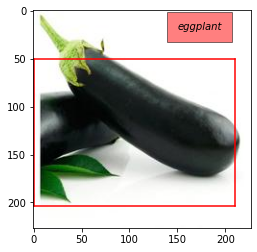

In [ ]:
import matplotlib.image as mpimg
from PIL import Image
img = Image.open('testc.jpg') # image extension *.png,*.jpg
new_width  = 227
new_height = 227
img = img.resize((new_width, new_height), Image.ANTIALIAS)
img.save('test.jpg') 
import cv2
im = cv2.imread('test.jpg')
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)   # BGR -> RGB
im = im[np.newaxis, ...]
test = model.predict(im)
classification = np.array([0,0,0])
classification[np.argmax(test[0][0])] = 1

i=1
plt.imshow(im[0,:, :, :]) #remove 1st dimension
plt.plot([test[i][0][0], test[i][0][0]], [test[i][0][1], test[i][0][3]], color='red')
plt.plot([test[i][0][0], test[i][0][2]], [test[i][0][1], test[i][0][1]], color='red')
plt.plot([test[i][0][0], test[i][0][2]], [test[i][0][3], test[i][0][3]], color='red')
plt.plot([test[i][0][2], test[i][0][2]], [test[i][0][1], test[i][0][3]], color='red')

if classification[0] == 1:
  text_class = 'cucumber'
elif classification[1] == 1:
  text_class = 'eggplant'
else:
  text_class = 'mushroom'
 
plt.text(150, 20, text_class, style='italic',
          bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 10})
plt.show()

# Filters and Feature Maps
**Finally, we will visualize the filters and the feature maps in the convolutional layers.**

In [ ]:
# summarize filter shapes
for layer in model.layers:
  # check for convolutional layer
  if 'conv' not in layer.name:
    continue
  # get filter weights
  filters, biases = layer.get_weights()
  print(layer.name, filters.shape)

conv2d (3, 3, 3, 64)
conv2d_4 (3, 3, 64, 128)
conv2d_1 (3, 3, 64, 64)
conv2d_5 (3, 3, 128, 192)
conv2d_2 (3, 3, 64, 128)
conv2d_6 (3, 3, 192, 256)
conv2d_3 (3, 3, 128, 192)
conv2d_7 (3, 3, 256, 320)


**These are the filters learned in the very first convolutional layer.**

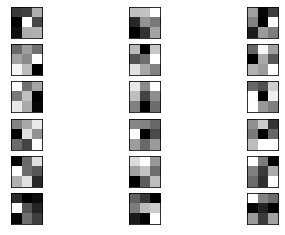

In [ ]:
# retrieve weights from the second hidden layer
filters, biases = model.layers[1].get_weights()

# normalize filter values to 0-1 so we can visualize them
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

# plot first few filters
n_filters, ix = 6, 1
for i in range(n_filters):
	# get the filter
	f = filters[:, :, :, i]
	# plot each channel separately
	for j in range(3):
		# specify subplot and turn of axis
		ax = plt.subplot(n_filters, 3, ix)
		ax.set_xticks([])
		ax.set_yticks([])
		# plot filter channel in grayscale
		plt.imshow(f[:, :, j], cmap='gray')
		ix += 1
# show the figure
plt.show()

In [ ]:
# summarize feature map shapes
for i in range(len(model.layers)):
	layer = model.layers[i]
	# check for convolutional layer
	if 'conv' not in layer.name:
		continue
	# summarize output shape
	print(i, layer.name, layer.output.shape)

1 conv2d (None, 227, 227, 64)
4 conv2d_4 (None, 113, 113, 128)
8 conv2d_1 (None, 113, 113, 64)
9 conv2d_5 (None, 56, 56, 192)
16 conv2d_2 (None, 56, 56, 128)
17 conv2d_6 (None, 28, 28, 256)
24 conv2d_3 (None, 28, 28, 192)
25 conv2d_7 (None, 14, 14, 320)


In [ ]:
# redefine model to output right after the first hidden layer
model_test = Model(inputs=model.inputs, outputs=model.layers[1].output)

**These are the feature maps in the very first layer.**

In [ ]:
# get feature map for first hidden layer
feature_maps = model_test.predict(im)

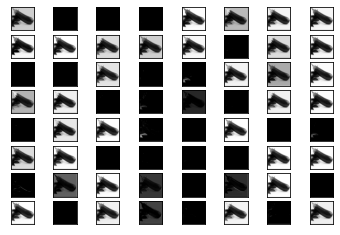

In [ ]:
square = 8
ix = 1
for _ in range(square):
	for _ in range(square):
		# specify subplot and turn of axis
		ax = plt.subplot(square, square, ix)
		ax.set_xticks([])
		ax.set_yticks([])
		# plot filter channel in grayscale
		plt.imshow(feature_maps[0, :, :, ix-1], cmap='gray')
		ix += 1
# show the figure
plt.show()

**Then, we will plot the feature maps in the classification part and in the regression part separately.**

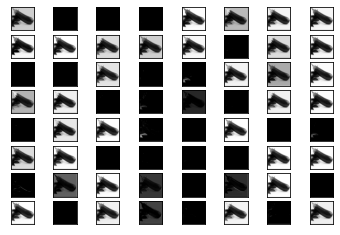

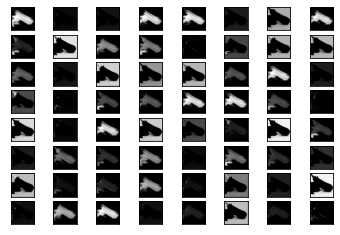

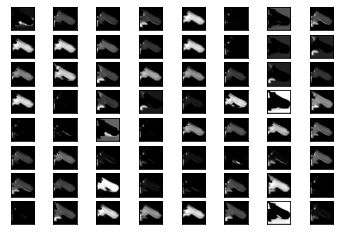

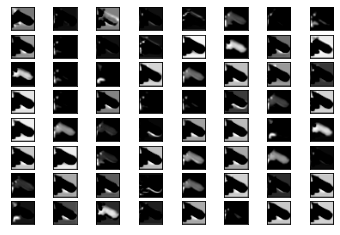

In [ ]:
#classification [1, 8, 16, 24]
#regression [4, 9, 17, 25]
ixs = [1, 8, 16, 24]
outputs = [model.layers[i].output for i in ixs]

# redefine model to output right after the first hidden layer
model_test = Model(inputs=model.inputs, outputs=outputs)
feature_maps = model_test.predict(im)

fig = plt.figure()

# plot the output from each block
square = 8
for fmap in feature_maps:
	# plot all 64 maps in an 8x8 squares
	ix = 1
	for _ in range(square):
		for _ in range(square):
			# specify subplot and turn of axis
			ax = plt.subplot(square, square, ix)
			ax.set_xticks([])
			ax.set_yticks([])
			# plot filter channel in grayscale
			plt.imshow(fmap[0, :, :, ix-1], cmap='gray')
			ix += 1
	# show the figure
	plt.show()

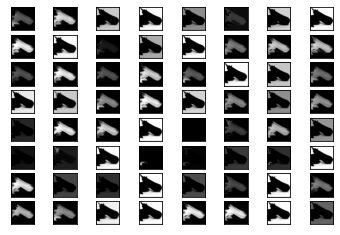

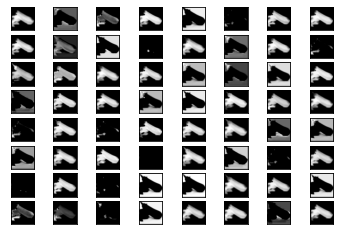

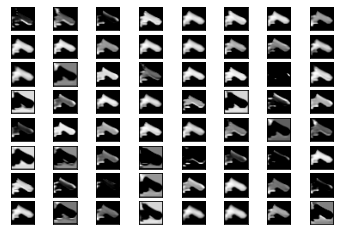

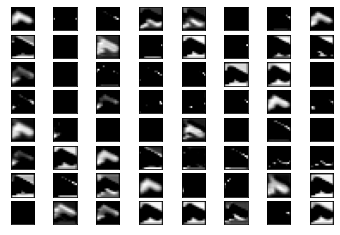

In [ ]:
#classification [1, 8, 16, 24]
#regression [4, 9, 17, 25]
ixs = [4, 9, 17, 25]
outputs = [model.layers[i].output for i in ixs]
# redefine model to output right after the first hidden layer
model_test = Model(inputs=model.inputs, outputs=outputs)
feature_maps = model_test.predict(im)

# plot the output from each block
square = 8
for fmap in feature_maps:
	# plot all 64 maps in an 8x8 squares
	ix = 1
	for _ in range(square):
		for _ in range(square):
			# specify subplot and turn of axis
			ax = plt.subplot(square, square, ix)
			ax.set_xticks([])
			ax.set_yticks([])
			# plot filter channel in grayscale
			plt.imshow(fmap[0, :, :, ix-1], cmap='gray')
			ix += 1
	# show the figure
	plt.show()

**As we can see, the learned filter are different between the classification and the regression part.**

**For the last part, let's test some images to confirm that the resulting model has learned to detect the object.**

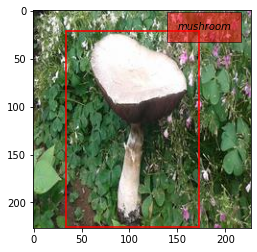

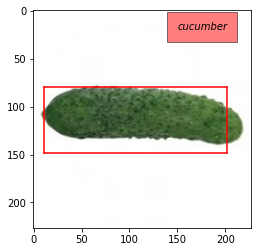

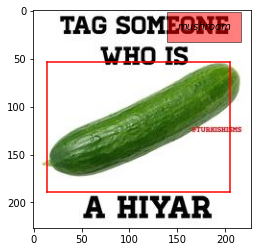

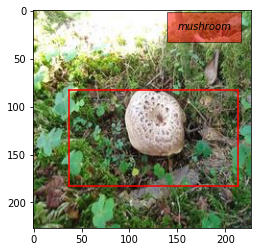

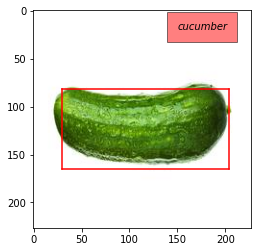

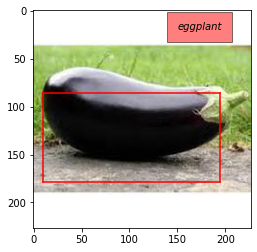

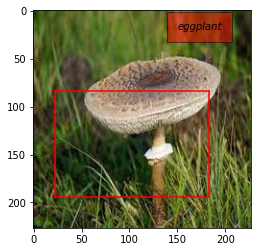

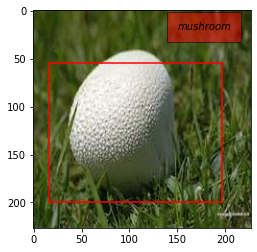

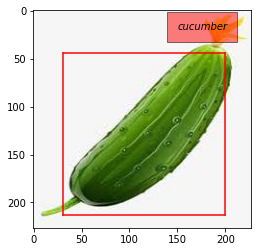

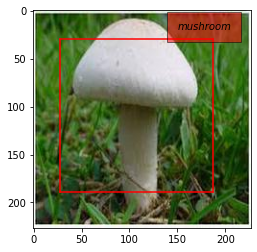

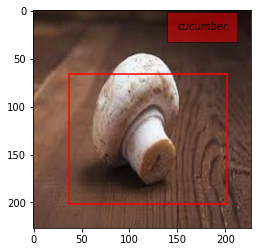

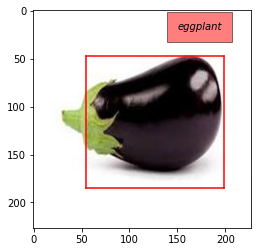

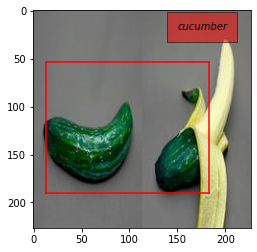

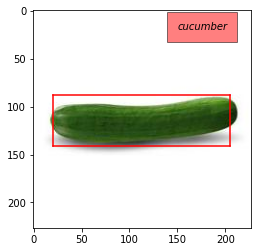

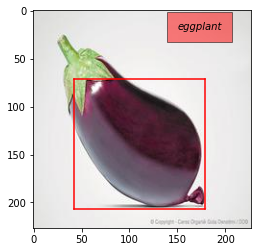

In [ ]:
for i in range(1,16):
  img = Image.open('%d.jpg'%i) # image extension *.png,*.jpg
  new_width  = 227
  new_height = 227
  img = img.resize((new_width, new_height), Image.ANTIALIAS)
  img.save('test.jpg') 
  im = cv2.imread('test.jpg')
  im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)   # BGR -> RGB
  im = im[np.newaxis, ...]
  test = model.predict(im)
  classification = np.array([0,0,0])
  classification[np.argmax(test[0][0])] = 1

  i=1
  plt.imshow(im[0,:, :, :]) #remove 1st dimension
  plt.plot([test[i][0][0], test[i][0][0]], [test[i][0][1], test[i][0][3]], color='red')
  plt.plot([test[i][0][0], test[i][0][2]], [test[i][0][1], test[i][0][1]], color='red')
  plt.plot([test[i][0][0], test[i][0][2]], [test[i][0][3], test[i][0][3]], color='red')
  plt.plot([test[i][0][2], test[i][0][2]], [test[i][0][1], test[i][0][3]], color='red')

  if classification[0] == 1:
    text_class = 'cucumber'
  elif classification[1] == 1:
    text_class = 'eggplant'
  else:
    text_class = 'mushroom'

  plt.text(150, 20, text_class, style='italic',
          bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 10})
  plt.show()

**As we observe, the model learned to distinguish the objects between those 3 categories very well. The part that the model lacks, is the part of placing the box surrounding the object, which could be due to the lack of sufficient number of data.**

# References
[1] https://towardsdatascience.com/demystifying-convolutional-neural-networks-using-gradcam-554a85dd4e48?gi=1de86d629869

[2] https://machinelearningmastery.com/how-to-visualize-filters-and-feature-maps-in-convolutional-neural-networks/

[3] https://github.com/MuhammedBuyukkinaci/Object-Classification-and-Localization-with-TensorFlow